# In-notebook SQL Analytics and Joins with DuckDB/SQLite

In medical data integration, we often need to combine data from multiple sources such as patient records, laboratory results, and imaging data. SQL databases provide powerful tools for joining and analyzing these datasets efficiently. This notebook demonstrates how to use DuckDB and SQLite directly within Jupyter notebooks for medical data analytics.

First, let's install and import the necessary libraries for working with DuckDB and SQLite in our notebook environment.

In [1]:
!pip install duckdb sqlite3 pandas numpy matplotlib seaborn

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


Now we'll import the required libraries for our analysis.

In [2]:
import duckdb
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

Let's create sample medical datasets that represent common scenarios in healthcare data integration. We'll create patient demographics, laboratory results, and medication records.

In [3]:
# Create sample patient demographics
np.random.seed(42)
n_patients = 1000

patients_df = pd.DataFrame({
    'patient_id': range(1, n_patients + 1),
    'age': np.random.randint(18, 90, n_patients),
    'gender': np.random.choice(['M', 'F'], n_patients),
    'admission_date': pd.date_range('2023-01-01', periods=n_patients, freq='6H'),
    'diagnosis_code': np.random.choice(['I25.9', 'E11.9', 'J44.1', 'N18.6'], n_patients)
})

print("Sample patient data:")
patients_df.head()

Sample patient data:


C:\Users\rober\AppData\Local\Temp\ipykernel_16540\2988652979.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'admission_date': pd.date_range('2023-01-01', periods=n_patients, freq='6H'),


,patient_id,age,gender,admission_date,diagnosis_code
0,1,69,M,2023-01-01 00:00:00,E11.9
1,2,32,M,2023-01-01 06:00:00,N18.6
2,3,89,F,2023-01-01 12:00:00,J44.1
3,4,78,M,2023-01-01 18:00:00,I25.9
4,5,38,M,2023-01-02 00:00:00,N18.6


Next, we'll generate laboratory results data with multiple test results per patient to simulate real clinical scenarios.

In [4]:
# Create sample laboratory results
lab_tests = ['glucose', 'creatinine', 'hemoglobin', 'cholesterol']
lab_data = []

for patient_id in range(1, n_patients + 1):
    # Each patient has 1-5 lab tests
    n_tests = np.random.randint(1, 6)
    selected_tests = np.random.choice(lab_tests, n_tests, replace=True)
    
    for test in selected_tests:
        if test == 'glucose':
            value = np.random.normal(100, 20)
        elif test == 'creatinine':
            value = np.random.normal(1.2, 0.3)
        elif test == 'hemoglobin':
            value = np.random.normal(13.5, 2.0)
        else:  # cholesterol
            value = np.random.normal(200, 40)
        
        lab_data.append({
            'patient_id': patient_id,
            'test_name': test,
            'test_value': round(value, 2),
            'test_date': patients_df.loc[patient_id-1, 'admission_date'] + timedelta(days=np.random.randint(0, 7))
        })

lab_results_df = pd.DataFrame(lab_data)
print(f"Generated {len(lab_results_df)} lab results")
lab_results_df.head(10)

Generated 2986 lab results


,patient_id,test_name,test_value,test_date
0,1,cholesterol,165.65,2023-01-07 00:00:00
1,2,creatinine,1.27,2023-01-05 06:00:00
2,2,hemoglobin,13.22,2023-01-01 06:00:00
3,2,cholesterol,151.03,2023-01-04 06:00:00
4,2,hemoglobin,13.08,2023-01-02 06:00:00
5,2,glucose,82.99,2023-01-02 06:00:00
6,3,glucose,114.40,2023-01-03 12:00:00
7,3,creatinine,1.63,2023-01-02 12:00:00
8,3,glucose,123.93,2023-01-04 12:00:00
9,4,creatinine,1.02,2023-01-06 18:00:00


Now let's create a medications dataset that we can later join with our patient and lab data.

In [5]:
# Create sample medication data
medications = ['metformin', 'lisinopril', 'atorvastatin', 'metoprolol', 'furosemide']
med_data = []

for patient_id in range(1, n_patients + 1):
    # Each patient has 0-3 medications
    n_meds = np.random.randint(0, 4)
    if n_meds > 0:
        selected_meds = np.random.choice(medications, n_meds, replace=False)
        
        for med in selected_meds:
            med_data.append({
                'patient_id': patient_id,
                'medication_name': med,
                'dosage_mg': np.random.choice([25, 50, 100, 200]),
                'start_date': patients_df.loc[patient_id-1, 'admission_date']
            })

medications_df = pd.DataFrame(med_data)
print(f"Generated {len(medications_df)} medication records")
medications_df.head(10)

Generated 1514 medication records


,patient_id,medication_name,dosage_mg,start_date
0,1,metformin,200,2023-01-01 00:00:00
1,1,lisinopril,50,2023-01-01 00:00:00
2,1,metoprolol,25,2023-01-01 00:00:00
3,2,metoprolol,25,2023-01-01 06:00:00
4,4,metformin,50,2023-01-01 18:00:00
5,4,metoprolol,200,2023-01-01 18:00:00
6,5,lisinopril,200,2023-01-02 00:00:00
7,5,furosemide,100,2023-01-02 00:00:00
8,5,metformin,50,2023-01-02 00:00:00
9,6,metoprolol,25,2023-01-02 06:00:00


## Working with DuckDB

DuckDB is an excellent choice for analytical workloads and can work directly with pandas DataFrames. Let's establish a connection and load our data.

In [6]:
# Create DuckDB connection
conn_duck = duckdb.connect(':memory:')
print("DuckDB connection established")
print(f"DuckDB version: {conn_duck.execute('SELECT version()').fetchone()[0]}")

DuckDB connection established
DuckDB version: v1.3.2


We'll register our pandas DataFrames as tables in DuckDB, making them available for SQL queries.

In [7]:
# Register pandas DataFrames as DuckDB tables
conn_duck.register('patients', patients_df)
conn_duck.register('lab_results', lab_results_df)
conn_duck.register('medications', medications_df)

print("Tables registered in DuckDB:")
tables = conn_duck.execute("SHOW TABLES").fetchall()
for table in tables:
    print(f"- {table[0]}")

Tables registered in DuckDB:
- lab_results
- medications
- patients


Let's perform a basic query to understand our patient demographics using SQL aggregation functions.

In [8]:
# Basic demographic analysis
demographic_query = """
SELECT 
    gender,
    COUNT(*) as patient_count,
    ROUND(AVG(age), 1) as avg_age,
    MIN(age) as min_age,
    MAX(age) as max_age
FROM patients 
GROUP BY gender
ORDER BY gender
"""

demographics_result = conn_duck.execute(demographic_query).df()
print("Patient Demographics:")
demographics_result

Patient Demographics:


,gender,patient_count,avg_age,min_age,max_age
0,F,497,54.0,18,89
1,M,503,51.8,18,89


Now let's perform an inner join to combine patient data with their laboratory results, which is a common operation in medical data analysis.

In [9]:
# Inner join: patients with lab results
join_query = """
SELECT 
    p.patient_id,
    p.age,
    p.gender,
    p.diagnosis_code,
    l.test_name,
    l.test_value,
    l.test_date
FROM patients p
INNER JOIN lab_results l ON p.patient_id = l.patient_id
WHERE p.age > 65
ORDER BY p.patient_id, l.test_name
LIMIT 20
"""

elderly_labs = conn_duck.execute(join_query).df()
print("Lab results for elderly patients (age > 65):")
elderly_labs

Lab results for elderly patients (age > 65):


,patient_id,age,gender,diagnosis_code,test_name,test_value,test_date
0,1,69,M,E11.9,cholesterol,165.65,2023-01-07 00:00:00
1,3,89,F,J44.1,creatinine,1.63,2023-01-02 12:00:00
2,3,89,F,J44.1,glucose,114.40,2023-01-03 12:00:00
3,3,89,F,J44.1,glucose,123.93,2023-01-04 12:00:00
4,4,78,M,I25.9,creatinine,1.02,2023-01-06 18:00:00
5,4,78,M,I25.9,creatinine,1.45,2023-01-04 18:00:00
6,4,78,M,I25.9,creatinine,1.44,2023-01-03 18:00:00
7,4,78,M,I25.9,creatinine,1.39,2023-01-06 18:00:00
8,9,70,M,I25.9,cholesterol,203.54,2023-01-07 00:00:00
9,9,70,M,I25.9,creatinine,1.64,2023-01-06 00:00:00


Let's perform a more complex analysis using a left join to find patients who may be missing certain lab tests, which is crucial for identifying gaps in care.

In [10]:
# Left join to find patients with specific diagnosis but missing glucose tests
missing_tests_query = """
SELECT 
    p.patient_id,
    p.diagnosis_code,
    p.age,
    CASE WHEN l.test_name IS NULL THEN 'Missing glucose test' 
         ELSE 'Has glucose test' END as glucose_status
FROM patients p
LEFT JOIN (
    SELECT DISTINCT patient_id, test_name 
    FROM lab_results 
    WHERE test_name = 'glucose'
) l ON p.patient_id = l.patient_id
WHERE p.diagnosis_code = 'E11.9'  -- Diabetes diagnosis
ORDER BY glucose_status, p.patient_id
LIMIT 15
"""

diabetes_glucose_check = conn_duck.execute(missing_tests_query).df()
print("Diabetes patients and their glucose test status:")
diabetes_glucose_check

Diabetes patients and their glucose test status:


,patient_id,diagnosis_code,age,glucose_status
0,6,E11.9,41,Has glucose test
1,29,E11.9,68,Has glucose test
2,31,E11.9,81,Has glucose test
3,32,E11.9,20,Has glucose test
4,34,E11.9,24,Has glucose test
5,67,E11.9,79,Has glucose test
6,72,E11.9,77,Has glucose test
7,73,E11.9,58,Has glucose test
8,74,E11.9,46,Has glucose test
9,79,E11.9,26,Has glucose test


Now let's perform a three-way join to get a comprehensive view of patients, their lab results, and medications.

In [11]:
# Three-way join for comprehensive patient view
comprehensive_query = """
SELECT 
    p.patient_id,
    p.age,
    p.diagnosis_code,
    l.test_name,
    l.test_value,
    m.medication_name,
    m.dosage_mg
FROM patients p
LEFT JOIN lab_results l ON p.patient_id = l.patient_id
LEFT JOIN medications m ON p.patient_id = m.patient_id
WHERE p.patient_id <= 10
ORDER BY p.patient_id, l.test_name, m.medication_name
"""

comprehensive_view = conn_duck.execute(comprehensive_query).df()
print("Comprehensive patient view (first 10 patients):")
comprehensive_view.head(20)

Comprehensive patient view (first 10 patients):


,patient_id,age,diagnosis_code,test_name,test_value,medication_name,dosage_mg
0,1,69,E11.9,cholesterol,165.65,lisinopril,50
1,1,69,E11.9,cholesterol,165.65,metformin,200
2,1,69,E11.9,cholesterol,165.65,metoprolol,25
3,2,32,N18.6,cholesterol,151.03,metoprolol,25
4,2,32,N18.6,creatinine,1.27,metoprolol,25
5,2,32,N18.6,glucose,82.99,metoprolol,25
6,2,32,N18.6,hemoglobin,13.22,metoprolol,25
7,2,32,N18.6,hemoglobin,13.08,metoprolol,25
8,3,89,J44.1,creatinine,1.63,None,<NA>
9,3,89,J44.1,glucose,123.93,None,<NA>


Let's calculate some clinical metrics using window functions to analyze glucose trends over time for diabetic patients.

In [12]:
# Window functions for glucose trend analysis
glucose_trend_query = """
SELECT 
    p.patient_id,
    p.diagnosis_code,
    l.test_value as glucose_level,
    l.test_date,
    AVG(l.test_value) OVER (PARTITION BY p.patient_id) as avg_glucose,
    ROW_NUMBER() OVER (PARTITION BY p.patient_id ORDER BY l.test_date) as test_sequence,
    CASE 
        WHEN l.test_value > 140 THEN 'High'
        WHEN l.test_value < 70 THEN 'Low'
        ELSE 'Normal'
    END as glucose_category
FROM patients p
INNER JOIN lab_results l ON p.patient_id = l.patient_id
WHERE l.test_name = 'glucose' AND p.diagnosis_code = 'E11.9'
ORDER BY p.patient_id, l.test_date
LIMIT 20
"""

glucose_trends = conn_duck.execute(glucose_trend_query).df()
print("Glucose trends for diabetic patients:")
glucose_trends

Glucose trends for diabetic patients:


,patient_id,diagnosis_code,glucose_level,test_date,avg_glucose,test_sequence,glucose_category
0,6,E11.9,133.62,2023-01-06 06:00:00,133.620,1,Normal
1,29,E11.9,73.44,2023-01-09 00:00:00,73.440,1,Normal
2,31,E11.9,108.59,2023-01-10 12:00:00,108.590,1,Normal
3,32,E11.9,107.65,2023-01-09 18:00:00,92.610,1,Normal
4,32,E11.9,77.57,2023-01-14 18:00:00,92.610,2,Normal
5,34,E11.9,86.45,2023-01-09 06:00:00,86.450,1,Normal
6,67,E11.9,96.85,2023-01-19 12:00:00,96.850,1,Normal
7,72,E11.9,89.83,2023-01-22 18:00:00,89.830,1,Normal
8,73,E11.9,105.84,2023-01-19 00:00:00,111.915,1,Normal
9,73,E11.9,117.99,2023-01-20 00:00:00,111.915,2,Normal


## Working with SQLite

Now let's demonstrate similar operations using SQLite, which is another popular embedded database option.

In [13]:
# Create SQLite connection and tables
conn_sqlite = sqlite3.connect(':memory:')

# Load DataFrames into SQLite
patients_df.to_sql('patients', conn_sqlite, if_exists='replace', index=False)
lab_results_df.to_sql('lab_results', conn_sqlite, if_exists='replace', index=False)
medications_df.to_sql('medications', conn_sqlite, if_exists='replace', index=False)

print("Data loaded into SQLite")
print(f"SQLite version: {sqlite3.sqlite_version}")

Data loaded into SQLite
SQLite version: 3.50.4


Let's perform a similar join operation in SQLite to identify medication patterns by diagnosis.

In [14]:
# Medication patterns by diagnosis in SQLite
med_pattern_query = """
SELECT 
    p.diagnosis_code,
    m.medication_name,
    COUNT(*) as prescription_count,
    ROUND(AVG(m.dosage_mg), 1) as avg_dosage
FROM patients p
INNER JOIN medications m ON p.patient_id = m.patient_id
GROUP BY p.diagnosis_code, m.medication_name
HAVING COUNT(*) >= 5
ORDER BY p.diagnosis_code, prescription_count DESC
"""

med_patterns = pd.read_sql_query(med_pattern_query, conn_sqlite)
print("Medication patterns by diagnosis (SQLite):")
med_patterns

Medication patterns by diagnosis (SQLite):


,diagnosis_code,medication_name,prescription_count,avg_dosage
0,E11.9,metformin,85,88.2
1,E11.9,atorvastatin,78,102.9
2,E11.9,furosemide,77,99.0
3,E11.9,metoprolol,76,93.4
4,E11.9,lisinopril,75,103.7
5,I25.9,metformin,83,94.9
6,I25.9,atorvastatin,81,92.0
7,I25.9,metoprolol,78,105.8
8,I25.9,furosemide,77,85.7
9,I25.9,lisinopril,75,96.3


Let's create a summary report using SQLite that combines multiple metrics for clinical dashboard purposes.

In [15]:
# Clinical summary report using SQLite
summary_query = """
SELECT 
    p.diagnosis_code,
    COUNT(DISTINCT p.patient_id) as total_patients,
    ROUND(AVG(p.age), 1) as avg_age,
    COUNT(DISTINCT l.patient_id) as patients_with_labs,
    COUNT(DISTINCT m.patient_id) as patients_with_meds,
    ROUND(
        100.0 * COUNT(DISTINCT l.patient_id) / COUNT(DISTINCT p.patient_id), 1
    ) as lab_coverage_pct
FROM patients p
LEFT JOIN lab_results l ON p.patient_id = l.patient_id
LEFT JOIN medications m ON p.patient_id = m.patient_id
GROUP BY p.diagnosis_code
ORDER BY total_patients DESC
"""

clinical_summary = pd.read_sql_query(summary_query, conn_sqlite)
print("Clinical Summary Report:")
clinical_summary

Clinical Summary Report:


,diagnosis_code,total_patients,avg_age,patients_with_labs,patients_with_meds,lab_coverage_pct
0,I25.9,264,50.9,264,200,100.0
1,N18.6,255,56.2,255,194,100.0
2,E11.9,255,49.7,255,195,100.0
3,J44.1,226,55.0,226,153,100.0


## Visualization of Query Results

Let's create some visualizations based on our SQL query results to demonstrate how database analytics integrate with data visualization.

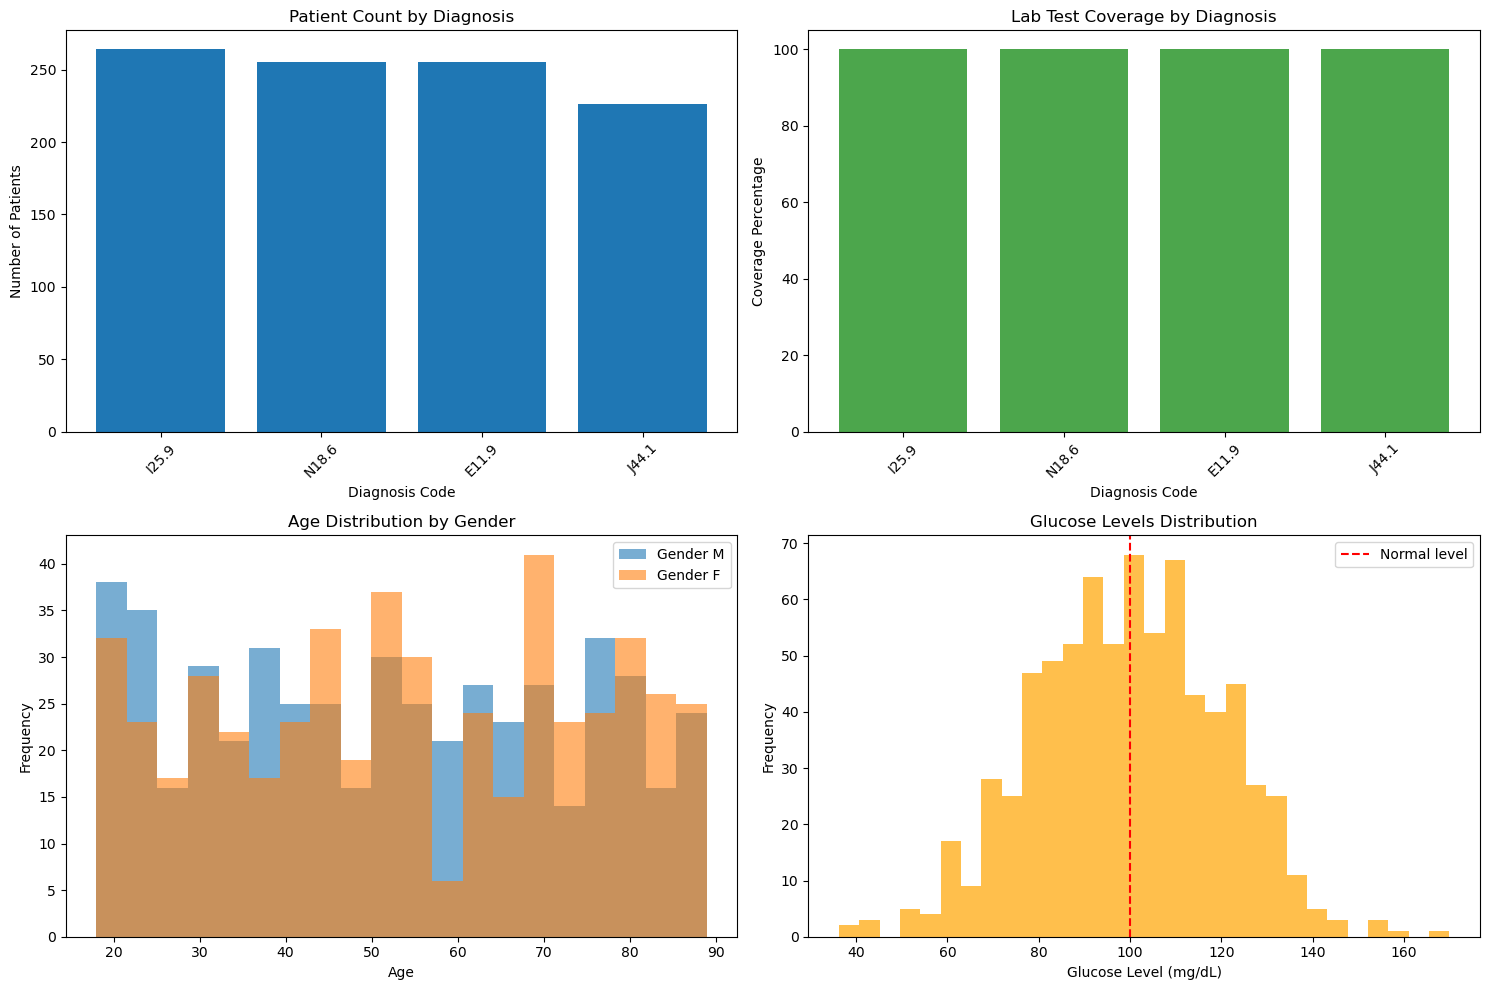

In [16]:
# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Patient count by diagnosis
ax1.bar(clinical_summary['diagnosis_code'], clinical_summary['total_patients'])
ax1.set_title('Patient Count by Diagnosis')
ax1.set_xlabel('Diagnosis Code')
ax1.set_ylabel('Number of Patients')
ax1.tick_params(axis='x', rotation=45)

# 2. Lab coverage by diagnosis
ax2.bar(clinical_summary['diagnosis_code'], clinical_summary['lab_coverage_pct'], color='green', alpha=0.7)
ax2.set_title('Lab Test Coverage by Diagnosis')
ax2.set_xlabel('Diagnosis Code')
ax2.set_ylabel('Coverage Percentage')
ax2.tick_params(axis='x', rotation=45)

# 3. Age distribution by gender
gender_age = conn_duck.execute("""
SELECT gender, age FROM patients
""").df()

for gender in ['M', 'F']:
    ages = gender_age[gender_age['gender'] == gender]['age']
    ax3.hist(ages, alpha=0.6, label=f'Gender {gender}', bins=20)
ax3.set_title('Age Distribution by Gender')
ax3.set_xlabel('Age')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Glucose levels distribution
glucose_data = conn_duck.execute("""
SELECT test_value FROM lab_results WHERE test_name = 'glucose'
""").df()

ax4.hist(glucose_data['test_value'], bins=30, alpha=0.7, color='orange')
ax4.axvline(x=100, color='red', linestyle='--', label='Normal level')
ax4.set_title('Glucose Levels Distribution')
ax4.set_xlabel('Glucose Level (mg/dL)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

Finally, let's clean up our database connections to free up resources.

In [17]:
# Close database connections
conn_duck.close()
conn_sqlite.close()
print("Database connections closed successfully")

Database connections closed successfully


## Key Takeaways

1. **DuckDB** excels at analytical queries and works seamlessly with pandas DataFrames
2. **SQLite** is excellent for persistent storage and standard SQL operations
3. **Joins** are essential for integrating medical data from multiple sources
4. **Window functions** help analyze trends and patterns in clinical data
5. **Left joins** are crucial for identifying missing data or gaps in care
6. SQL results can be easily visualized using standard Python plotting libraries

## Exercise

**Clinical Data Integration Challenge**

Using the techniques learned in this notebook, complete the following tasks:

1. **Create a new dataset** for "vital signs" with patient_id, measurement_type (blood_pressure, heart_rate, temperature), measurement_value, and measurement_date

2. **Write SQL queries** to:
   - Find patients who have both high glucose levels (>140) AND are taking metformin
   - Identify patients with heart disease diagnosis (I25.9) who are missing cholesterol tests
   - Calculate the average number of different medication types per diagnosis

3. **Perform a four-way join** between patients, lab_results, medications, and your new vital_signs table to create a comprehensive patient health summary

4. **Create visualizations** showing:
   - The relationship between age and number of medications
   - Distribution of lab test completion rates by diagnosis

5. **Compare performance** between DuckDB and SQLite for your most complex query and discuss which would be better for different use cases in medical data integration

Document your findings and explain how these SQL techniques would be valuable in real-world medical data integration scenarios.